In [1]:
# Simulation / bootstrapping and Fixed Effects

In [2]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import root_mean_squared_error

## Fixed Effects
Separating the average effect of each group of samples (the **between-group effect**, captured by $\beta_i$), from the effect of one or more variables associated with all of the samples (the **within-group effect**, captured by $\beta_1$).

In [3]:
scipy.stats.norm.rvs(0, 1, (5,)) # create a random sample of 5 numbers from a normal distribution with mean 0 and standard deviation 1

array([ 0.39369523, -0.08106736, -0.01665061,  0.76112146, -0.00639275])

This first example uses 3 groups with randomly generated samples using the normal distribution:

X1, X2, X3 are all normally distributed

Y values:

$$Y_1 \; = \; 3 (\beta_1)  \times X_1 + 5 + \epsilon (\text{random noise})$$

In [4]:
# make an example with 3 groups, each using the scipy stats.norm.rvs function to generate random samples
num = 1000
X1 = scipy.stats.norm.rvs(0, 1, (num,))
X2 = scipy.stats.norm.rvs(0, 1, (num,))
X3 = scipy.stats.norm.rvs(0, 1, (num,))
Y1 = 3 * X1 + 5 + scipy.stats.norm.rvs(0, 1, (num,)) 
Y2 = 3 * X2 + 10 + scipy.stats.norm.rvs(0, 1, (num,))
Y3 = 3 * X3 + 15 + scipy.stats.norm.rvs(0, 1, (num,))

In [5]:
results = sm.OLS(Y1, sm.add_constant(X1)).fit() #fit a linear regression model to the first group

In [6]:
results.params # this will give you the coefficients of the linear regression model, including the intercept and the slope for X1

array([5.00448592, 3.07348085])

In [7]:
results.bse # this will give you the standard errors of the coefficients

array([0.03171863, 0.03177729])

In [8]:
results.rsquared # this will give you the R-squared value of the linear regression model, which is a measure of how well the model fits the data

0.9035995215471792

In [9]:
np.std(results.resid) # this will give you the standard deviation of the residuals, which is a measure of how much the model's predictions deviate from the actual values

1.002023671001723

In [10]:
np.std(results.resid) # (resid_0 - resid_mean)^2 + (resid_1 - resid_mean)^2 + ....

1.002023671001723

In [11]:
root_mean_squared_error(Y1, results.predict(sm.add_constant(X1))) # Another way
# (resid_0)^2 + (resid_1)^2 + ....

1.002023671001723

In [12]:
results.resid.mean()

-1.1901590823981679e-15

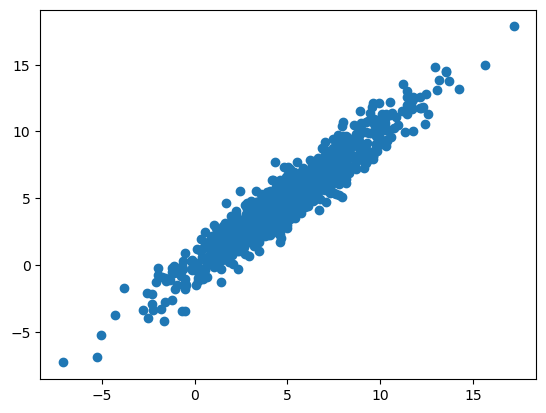

In [13]:
plt.scatter(results.predict(sm.add_constant(X1)), Y1)

So this is stage one, we haven't done fixed effects yet, we've just looked at the linear relationships between the variables.  Now let's move on to fixed effects modeling. Let's combine X1, X2, X3 and Y1, Y2, Y3 and find a common equation for them. 

In [14]:
Y = np.hstack((Y1, Y2, Y3)) #combine the Y values from all groups
X = np.hstack((X1, X2, X3)) #combine the X values from all groups
results_combined = sm.OLS(Y, sm.add_constant(X)).fit()
results_combined.params # note that params do not match group 1, but likely will match group 2 

array([10.01011367,  3.07796017])

In [15]:
results_combined.bse

array([0.07682071, 0.07845442])

In [16]:
results_combined.rsquared # rsquared is _worse_ than for group 1 alone

0.33923807671912243

In [17]:
np.std(results_combined.resid)

4.205757189961178

In [18]:
root_mean_squared_error(Y, results_combined.predict(sm.add_constant(X))) # another way

4.205757189961178

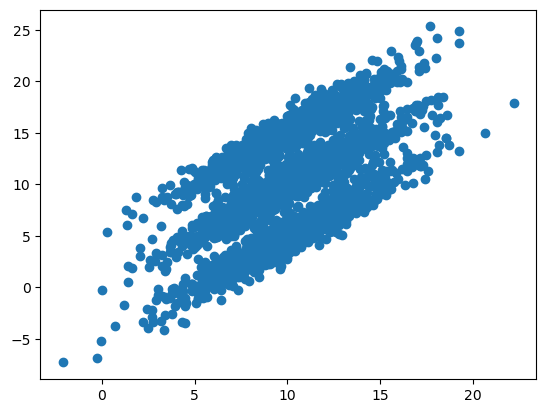

In [19]:
plt.scatter(results_combined.predict(sm.add_constant(X)), Y) #scatter plot of the predicted values vs the actual values for the combined model, you can see the 3 groups from the original equations. Lumping them together is not going to work. 

In [20]:
np.repeat([0, 1, 2], 5) # this will create an array with 5 zeros, 5 ones, and 5 twos, which can be used as a group identifier for fixed effects modeling

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2])

In [21]:
pd.get_dummies(np.repeat([0, 1, 2], 5), drop_first = True) # this will create a DataFrame with dummy variables for the group identifiers, dropping the first group to avoid multicollinearity

,1,2
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
5,True,False
6,True,False
7,True,False
8,True,False
9,True,False


In [22]:
groups = np.repeat([0, 1, 2], num) # create a group identifier for each observation, where 0 corresponds to group 1, 1 corresponds to group 2, and 2 corresponds to group 3
X_fixed_effects = pd.get_dummies(groups, drop_first=True) # create dummy variables for the group identifiers, dropping the first group to avoid multicollinearity
X_design = np.hstack((X.reshape(-1, 1), X_fixed_effects)) # combine the X values with the dummy variables for the group identifiers
df_design = pd.DataFrame(X_design, columns = ["X", "Group_1", "Group_2"]) # create a DataFrame with the combined X values and the dummy variables for the group identifiers
results_fixed_effects = sm.OLS(Y, sm.add_constant(df_design)).fit() # fit a linear regression model with fixed effects

In [23]:
groups

array([0, 0, 0, ..., 2, 2, 2])

In [24]:
X_fixed_effects

,1,2
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
2995,False,True
2996,False,True
2997,False,True
2998,False,True


In [25]:
X_design

array([[ 0.91651274,  0.        ,  0.        ],
       [-0.76238544,  0.        ,  0.        ],
       [-0.4049399 ,  0.        ,  0.        ],
       ...,
       [-0.79970388,  0.        ,  1.        ],
       [ 0.74291571,  0.        ,  1.        ],
       [ 0.93100535,  0.        ,  1.        ]])

In [26]:
df_design

,X,Group_1,Group_2
0,0.916513,0.0,0.0
1,-0.762385,0.0,0.0
2,-0.404940,0.0,0.0
3,1.490328,0.0,0.0
4,-0.066501,0.0,0.0
...,...,...,...
2995,-0.179659,0.0,1.0
2996,-0.629455,0.0,1.0
2997,-0.799704,0.0,1.0
2998,0.742916,0.0,1.0


In [27]:
df_design.head()

,X,Group_1,Group_2
0,0.916513,0.0,0.0
1,-0.762385,0.0,0.0
2,-0.404940,0.0,0.0
3,1.490328,0.0,0.0
4,-0.066501,0.0,0.0


In [28]:
results_fixed_effects.params

const       5.004571
X           3.043439
Group_1     5.002879
Group_2    10.015285
dtype: float64

In [29]:
results_fixed_effects.bse

const      0.031196
X          0.018397
Group_1    0.044118
Group_2    0.044119
dtype: float64

In [30]:
results_fixed_effects.rsquared

0.9636949563029135

In [31]:
np.std(results_fixed_effects.resid)

0.9858371356930011

In [32]:
root_mean_squared_error(Y, results_fixed_effects.predict(sm.add_constant(df_design)))

0.9858371356930018

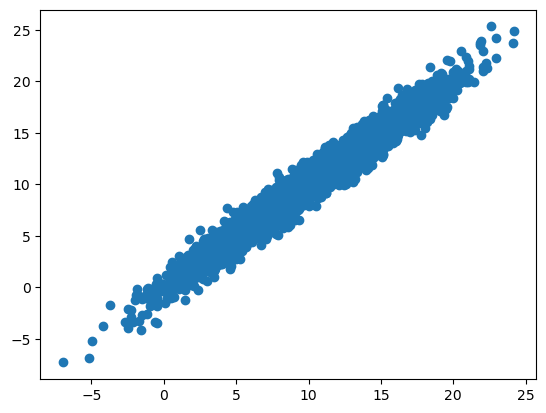

In [33]:
plt.scatter(results_fixed_effects.predict(sm.add_constant(df_design)), Y)

In [34]:
X = np.hstack((X1 - X1.mean(), X2 - X2.mean(), X3 - X3.mean())) # easy way to demean the X values
Y = np.hstack((Y1 - Y1.mean(), Y2 - Y2.mean(), Y3 - Y3.mean()))
results_demeaned = sm.OLS(Y, X).fit()

In [35]:
results_demeaned.rsquared

0.9013317526122937

In [36]:
np.std(results_demeaned.resid)

0.9858371356930017

In [37]:
root_mean_squared_error(Y, results_demeaned.predict(X))

0.9858371356930017

In [38]:
# Suppose we want to know what happens if we do this simulation many times
num_iter = 1000
beta_1_list = list()
se_list = list()
for n in range(num_iter):
    num = 1000
    X1 = scipy.stats.norm.rvs(0, 1, (num,))
    X2 = scipy.stats.norm.rvs(0, 1, (num,))
    X3 = scipy.stats.norm.rvs(0, 1, (num,))
    Y1 = 3 * X1 + 5 + scipy.stats.norm.rvs(0, 1, (num,))
    Y2 = 3 * X2 + 10 + scipy.stats.norm.rvs(0, 1, (num,))
    Y3 = 3 * X3 + 15 + scipy.stats.norm.rvs(0, 1, (num,))
    X = np.hstack((X1 - X1.mean(), X2 - X2.mean(), X3 - X3.mean())) # demean the data
    Y = np.hstack((Y1 - Y1.mean(), Y2 - Y2.mean(), Y3 - Y3.mean()))
    results_demeaned = sm.OLS(Y, X).fit()
    beta_1_list.append(results_demeaned.params[0])
    se_list.append(results_demeaned.bse[0])
 
np.std(beta_1_list)

0.0180830703413747

In [39]:
np.std(beta_1_list), np.mean(beta_1_list)

(0.0180830703413747, 3.0007131710345973)

In [40]:
np.std(se_list), np.mean(se_list)

(0.0003448960692543697, 0.01825336313191976)

In [41]:
np.mean(beta_1_list)

3.0007131710345973

(array([  4.,   2.,  11.,  23.,  46.,  57.,  94., 104., 132., 133., 122.,
         92.,  84.,  41.,  26.,  11.,   7.,   4.,   5.,   2.]),
 array([2.94600179, 2.95194552, 2.95788925, 2.96383297, 2.9697767 ,
        2.97572043, 2.98166416, 2.98760788, 2.99355161, 2.99949534,
        3.00543907, 3.01138279, 3.01732652, 3.02327025, 3.02921398,
        3.0351577 , 3.04110143, 3.04704516, 3.05298889, 3.05893261,
        3.06487634]),
 <BarContainer object of 20 artists>)

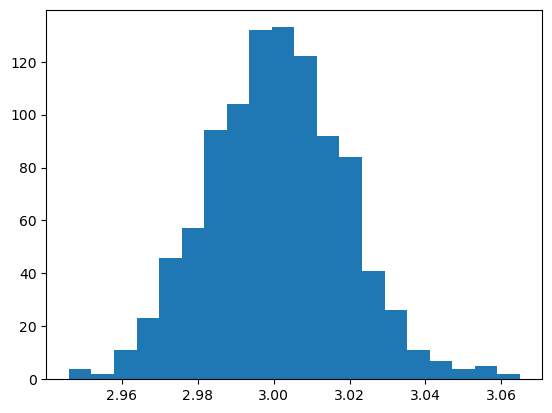

In [42]:
plt.hist(beta_1_list, bins = 20)

(array([  3.,   6.,  14.,  22.,  49.,  89., 110., 152., 142., 135., 113.,
         83.,  43.,  19.,  13.,   3.,   2.,   0.,   1.,   1.]),
 array([0.0171682 , 0.01729692, 0.01742563, 0.01755435, 0.01768307,
        0.01781178, 0.0179405 , 0.01806922, 0.01819793, 0.01832665,
        0.01845537, 0.01858409, 0.0187128 , 0.01884152, 0.01897024,
        0.01909895, 0.01922767, 0.01935639, 0.0194851 , 0.01961382,
        0.01974254]),
 <BarContainer object of 20 artists>)

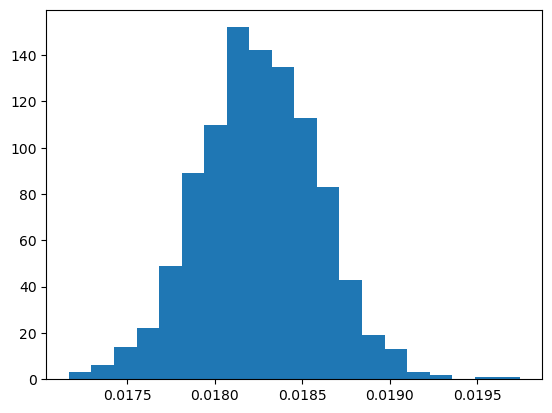

In [43]:
plt.hist(se_list, bins = 20)